# Test CCAT M1 Model

In [1]:
import torch as torch
from torch.utils.data import *
import torch.nn.functional as F
import numpy as np
from os import path
from ccarM3model import *
from tqdm import tqdm, trange, tqdm_notebook
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TEST_PATH = '/home/user/notebooks/data/test'
MODEL_PATH = '/home/user/notebooks/data/model/ccarM3/20190830_150600/'
MODEL_SAVED = MODEL_PATH + '/ccarM3.pth'

## Plot Loss Curves

In [3]:
checkpoint = torch.load(MODEL_SAVED)

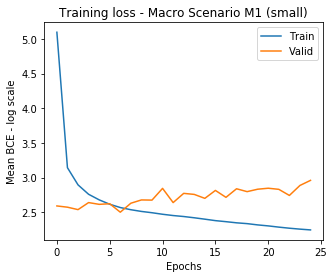

In [4]:
plt.figure(1, figsize=[5, 4])
plt.plot(checkpoint['train_losses'], label='Train')
plt.plot(checkpoint['valid_losses'], label='Valid')
plt.xlabel("Epochs")
plt.ylabel('Mean BCE - log scale')
plt.legend(loc='best') 
plt.title('Training loss - Macro Scenario M1 (small)')
plt.savefig(MODEL_PATH+'/loss.png', dpi=200)

## Test Data

In [5]:
t_acq, t_idx_to_seq, t_seq, t_macros, t_ym2idx = load_data(TEST_PATH, True, False)

Loading: /home/user/notebooks/data/test/fnm_input_seq_0.90.npy:   0%|          | 0/5 [00:00<?, ?it/s]

Acquisition: /home/user/notebooks/data/test/fnm_input_acq.npy
Sequence: /home/user/notebooks/data/test/fnm_input_seq_*.npy
Index to Sequence Index: /home/user/notebooks/data/test/fnm_input_idx_to_seq.npy
Macros: /home/user/notebooks/data/test/fred_norm.npy
YYYYMM to Index: /home/user/notebooks/data/test/ym2idx.pickle
loading seq_chunk


Loading: /home/user/notebooks/data/test/fnm_input_seq_0.98.npy: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


In [6]:
BATCH_SIZE = 256 
NUM_WORKERS = 6

In [7]:
test_ds = FNMCCARDataset(t_acq, t_idx_to_seq, t_seq, t_macros, t_ym2idx, 12, 0)

Initial acq: 2,541,605
Non-short acq: 2,541,159


In [8]:
testDL = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle = True, \
        collate_fn=paddingCollator, num_workers=NUM_WORKERS, pin_memory=True)

In [10]:
    model_params = {
        'seq_n_features': FNMCCARDataset.seq_n_features,
        'encoder' : {
            'emb_acq_dims' : [('state_id',   55, 25), 
                            ('purpose_id', 5, 2),
                            ('mi_type_id', 4, 2),
                            ('occupancy_status_id', 4, 2), 
                            ('product_type_id', 2, 2), 
                            ('property_type_id', 6, 2), 
                            ('seller_id', 95, 40), 
                            ('zip3_id', 1001, 50)],
            'emb_seq_dims' : [('yyyymm', 219, 50), 
                            ('msa_id', 407, 50), 
                            ('servicer_id', 46, 23)],
            'lstm' : {
                'lstm_size': 400,
                'lstm_layers': 3,
                'lstm_dropout': 0.2
            },
            'lin_block' : [
                (200, 0.2),
                (100, 0.2),
                (50,  0.2)
            ]
        },
        'decoder' : {
            'input_size': 50,
            'pre_lin_conf': [
                (50, 0.2)
            ],
            'lstm' : {
                'input_size' : 73, # 50 + 9 + macros
                'lstm_size': 100,
                'lstm_layers': 3,
                'lstm_dropout': 0.2
            },
            'post_lin_conf' : [
                (75, 0.1),
                (50, 0.1),
                (9, 0.1) # DLQ is from 0 to 8
            ]
        }
    }

In [10]:
# version - shmersion
model_params = {
    'seq_n_features': FNMCCARDataset.seq_n_features,
    'encoder' : {
        'emb_acq_dims' : [('state_id',   55, 25), 
                        ('purpose_id', 5, 2),
                        ('mi_type_id', 4, 2),
                        ('occupancy_status_id', 4, 2), 
                        ('product_type_id', 2, 2), 
                        ('property_type_id', 6, 2), 
                        ('seller_id', 95, 40), 
                        ('zip3_id', 1001, 50)],
        'emb_seq_dims' : [('yyyymm', 219, 50), 
                        ('msa_id', 407, 50), 
                        ('servicer_id', 46, 23)],
        'lstm' : {
            'lstm_size': 300,
            'lstm_layers': 5,
            'lstm_dropout': 0.2
        },
        'lin_block' : [
            (200, 0.2),
            (100, 0.2),
            (50,  0.2)
        ]
    },
    'decoder' : {
        'input_size': 50,
        'pre_lin_conf': [
            (50, 0.2)
        ],
        'lstm' : {
            'input_size' : 73, # 50 + 9 + macros
            'lstm_size': 100,
            'lstm_layers': 5,
            'lstm_dropout': 0.2
        },
        'post_lin_conf' : [
            (50, 0.1),
            (9, 0.1) # DLQ is from 0 to 8
        ]
    }
}

In [11]:
model = makeModel(model_params)
loss_function = nn.CrossEntropyLoss(reduction='sum',  ignore_index=8) # 8 is EOS
optimizer = optim.Adam(params=model.parameters())

In [12]:
fitCtx = TrainingContext(
    MODEL_SAVED, 
    model, 
    loss_function, 
    optimizer, 
    testDL, 
    testDL,
    0,
    0
)

fitCtx.useGPU(True)
checkpoint_epoch = fitCtx.loadModel()
fitCtx.makeParallel(True)

Using device: cuda
Loading model checkpoint: /home/user/notebooks/data/model/ccarM3/20190830_150600//ccarM3.pth
Training on 2 GPUs


In [13]:
target_vec = np.zeros((len(test_ds), 12), dtype=np.int32)
target_hat_mat = np.zeros((len(test_ds), 9, 12), dtype=np.float32)
last_dlq = -1*np.ones((len(test_ds)))
losses = []

In [ ]:
fitCtx.model.eval()
with torch.no_grad():
    tq = tqdm(testDL)
    for bidx, (seq, seq_len, ymd, acq, macro_pred, target) in enumerate(tq):
        target_vec[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :] = target.detach().cpu().numpy()
        last_dlq[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE] = np.argmax(seq[:, -1, -9:].detach().cpu().numpy())

        target_hat = fitCtx.model(seq, seq_len, ymd, acq, macro_pred)
        target = target.to(target_hat.device)
        loss = loss_function(target_hat, target)
        losses.append(loss.item())
        
        target_hat = F.softmax(target_hat, dim=1)
        target_hat_mat[bidx*BATCH_SIZE:(bidx+1)*BATCH_SIZE, :, :] = target_hat.detach().cpu().numpy()

  6%|▌         | 619/9927 [01:01<13:47, 11.25it/s] 

In [18]:
np.mean(losses)/testDL.batch_size

0.9193818432945877

## Build ROC Curve

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Calculate corresponding 1 year default rate

In [20]:
def_score = np.sum(target_hat_mat[:, 7:, :], axis=1)

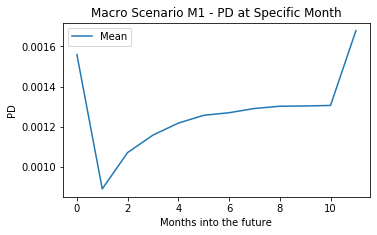

In [21]:
plt.figure(1, figsize=[5.5, 3.2])
plt.plot(np.mean(def_score, axis=0), label='Mean')
plt.xlabel('Months into the future')
plt.ylabel('PD')
plt.title('Macro Scenario M1 - PD at Specific Month')
plt.legend(loc='best') 
plt.savefig(MODEL_PATH+'/mean_pd.png', dpi=100)

In [22]:
def1y_score = 1-np.prod(1-def_score, axis=1)
def1y_target = 1*(np.max(target_vec, axis=1) >= 7)

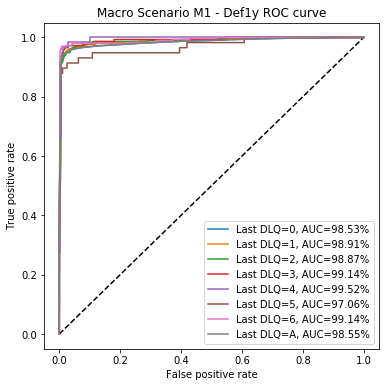

In [23]:
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(1, figsize=[6, 6])
plt.plot([0, 1], [0, 1], 'k--')
for dlq in range(7):
    idx = np.where(last_dlq==dlq)
    fpr[dlq], tpr[dlq], _ = roc_curve(def1y_target[idx], def1y_score[idx])
    roc_auc[dlq] = auc(fpr[dlq], tpr[dlq])
    plt.plot(fpr[dlq], tpr[dlq], label='Last DLQ={}, AUC={:.2f}%'.format(dlq, roc_auc[dlq]*100))
fpr[-1], tpr[-1], _ = roc_curve(def1y_target, def1y_score)
roc_auc[-1] = auc(fpr[-1], tpr[-1])
plt.plot(fpr[-1], tpr[-1], label='Last DLQ=A, AUC={:.2f}%'.format(roc_auc[-1]*100))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Macro Scenario M1 - Def1y ROC curve')
plt.legend(loc='best')
plt.savefig(MODEL_PATH+'/def1y_roc.png', dpi=200)

In [35]:
target_hat_mat[0, :, 0]

array([9.9976331e-01, 2.1012739e-04, 1.1568288e-05, 5.7434981e-06,
       4.0308782e-06, 3.1831214e-06, 1.8354976e-06, 1.6342364e-07,
       9.8030299e-08], dtype=float32)

In [ ]:
dlq_predicted = np.argmax(target_hat_mat, axis=1)
defaults_predicted = 1*(np.max(dlq_predicted, axis=1) > 6)